## Imports and helper function

In [ ]:
# Imports and helper functions for data analysis and visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from matplotlib import gridspec
from scipy import stats 
from sklearn.preprocessing import MinMaxScaler



In [2]:
# Helper function: generic station cluster scatter plot
def plot_station_clusters(df, lon_col='station_longitude', lat_col='station_latitude', cluster_col='station_cluster'):
    """
    Scatterplot of stations colored by cluster.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with station coordinates and a cluster label.
    lon_col : str
        Name of longitude column.
    lat_col : str
        Name of latitude column.
    cluster_col : str
        Name of cluster label column.
    """
    n_clusters = len(set(df[cluster_col]))
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(
        data=df,
        x=lon_col,
        y=lat_col,
        hue=cluster_col,
        palette='tab20',
        ax=ax,
        alpha=0.7
    )
    ax.set_title(f'Station Clusters (n={n_clusters})')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Load data and basic structure

In [ ]:
# Load station data from CSV file and inspect its structure

data= pd.read_csv('../data/Trips_2018.csv')

# stations= pd.read_csv('../data/Trips_2018.csv')
stations = pd.read_csv("/Users/alexnaderspude/Desktop/Desktop/TUM MMT/DTU Kurs/Group Project/Trips_2018.csv")

# Rename to simpler coordinate names used later
stations = stations.rename(
    columns={
        "start_station_latitude": "station_latitude",
        "start_station_longitude": "station_longitude",
    }
)
stations = stations[stations['category'] != 'No station id'].copy()
stations.info()
stations.head().T


KeyError: 'category'

## Clean station coordinates & deduplicate stations

In [ ]:
# Clean stations: round coordinates and remove duplicates

# Round coordinates to avoid tiny floating point differences between same stations
stations['station_latitude'] = stations['station_latitude'].round(4)
stations['station_longitude'] = stations['station_longitude'].round(4)

# Keep one row per start_station_id + coordinate combination (station-level dataset)
stations = stations.drop_duplicates(
    subset=['start_station_id', 'station_latitude', 'station_longitude']
).reset_index(drop=True)

print("Number of unique start stations:", stations['start_station_id'].nunique())
print(stations.columns)


Number of unique start stations: 818
Index(['Unnamed: 0', 'tripduration', 'starttime', 'stoptime',
       'start_station_id', 'station_latitude', 'station_longitude',
       'end_station_id', 'end_station_latitude', 'end_station_longitude',
       'bikeid', 'usertype', 'birth_year', 'gender'],
      dtype='object')


## Top stations by number of records

In [ ]:
# Top 5 stations by number of bike rentals in the dataset.

top5 = (
    stations
    .groupby('start_station_id')
    .size()
    .reset_index(name='counts')
    .sort_values(by='counts', ascending=False)
    .head(5)
)

print("Top 5 stations by number of rows in stations DataFrame:")
print(top5)


Top 5 stations by number of rows in stations DataFrame:
     start_station_id  counts
0                72.0       1
549            3389.0       1
539            3377.0       1
540            3378.0       1
541            3379.0       1


## Elbow method (K-Means: choose k)

/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/2884417380.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', k)


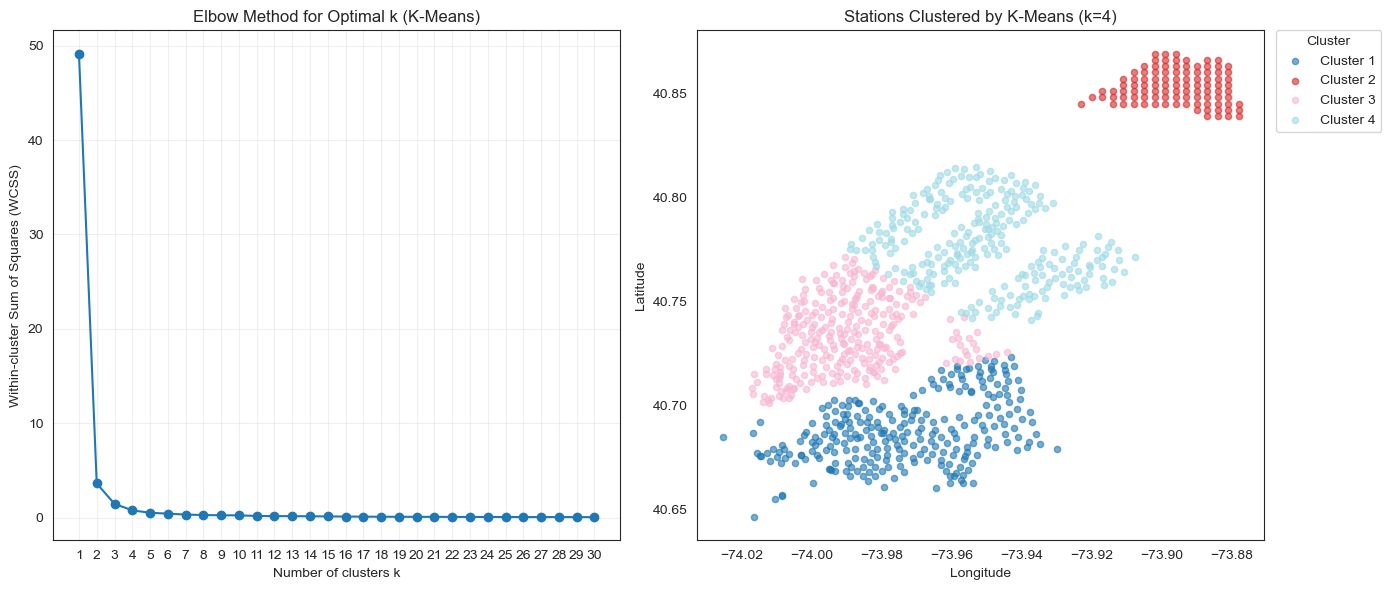

In [ ]:
# Set up K-Means clustering and elbow method to find optimal k

# Elbow method
def elbow_method(data, max_k):
    """
    Compute within-cluster sum of squares (SSE/WCSS) for k = 1..max_k.
    """
    sse = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)  # inertia_ = sum of squared distances to centroids
    return sse

coords_for_clustering = stations[['station_longitude', 'station_latitude']]
sse = elbow_method(coords_for_clustering, max_k=30)

# Create K-means clusters based on elbow method (k = 4)
k = 4 
# Remove spatial outliers (only for clustering & plotting)
coords = stations[['station_latitude', 'station_longitude']]
z_scores = np.abs(stats.zscore(coords))
mask_no_outliers = (z_scores < 3).all(axis=1)
stations_clean = stations[mask_no_outliers].copy()

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(stations_clean[['station_latitude', 'station_longitude']])
stations_clean['station_cluster'] = kmeans.labels_ + 1  # clusters start at 1

# Create side-by-side plots
fig, (ax_elbow, ax_map) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Elbow plot
ax_elbow.plot(range(1, 31), sse, marker='o')
ax_elbow.set_title('Elbow Method for Optimal k (K-Means)')
ax_elbow.set_xlabel('Number of clusters k')
ax_elbow.set_ylabel('Within-cluster Sum of Squares (WCSS)')
ax_elbow.set_xticks(range(1, 31))
ax_elbow.grid(alpha=0.3)

# Right: K-Means clusters (k = 4)
cmap = plt.cm.get_cmap('tab20', k)
for c in range(1, k + 1):
    m = stations_clean['station_cluster'] == c
    ax_map.scatter(
        stations_clean.loc[m, 'station_longitude'],
        stations_clean.loc[m, 'station_latitude'],
        color=cmap(c - 1),
        alpha=0.6,
        s=20,
        label=f'Cluster {c}'
    )

ax_map.set_title(f'Stations Clustered by K-Means (k={k})')
ax_map.set_xlabel('Longitude')
ax_map.set_ylabel('Latitude')
ax_map.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


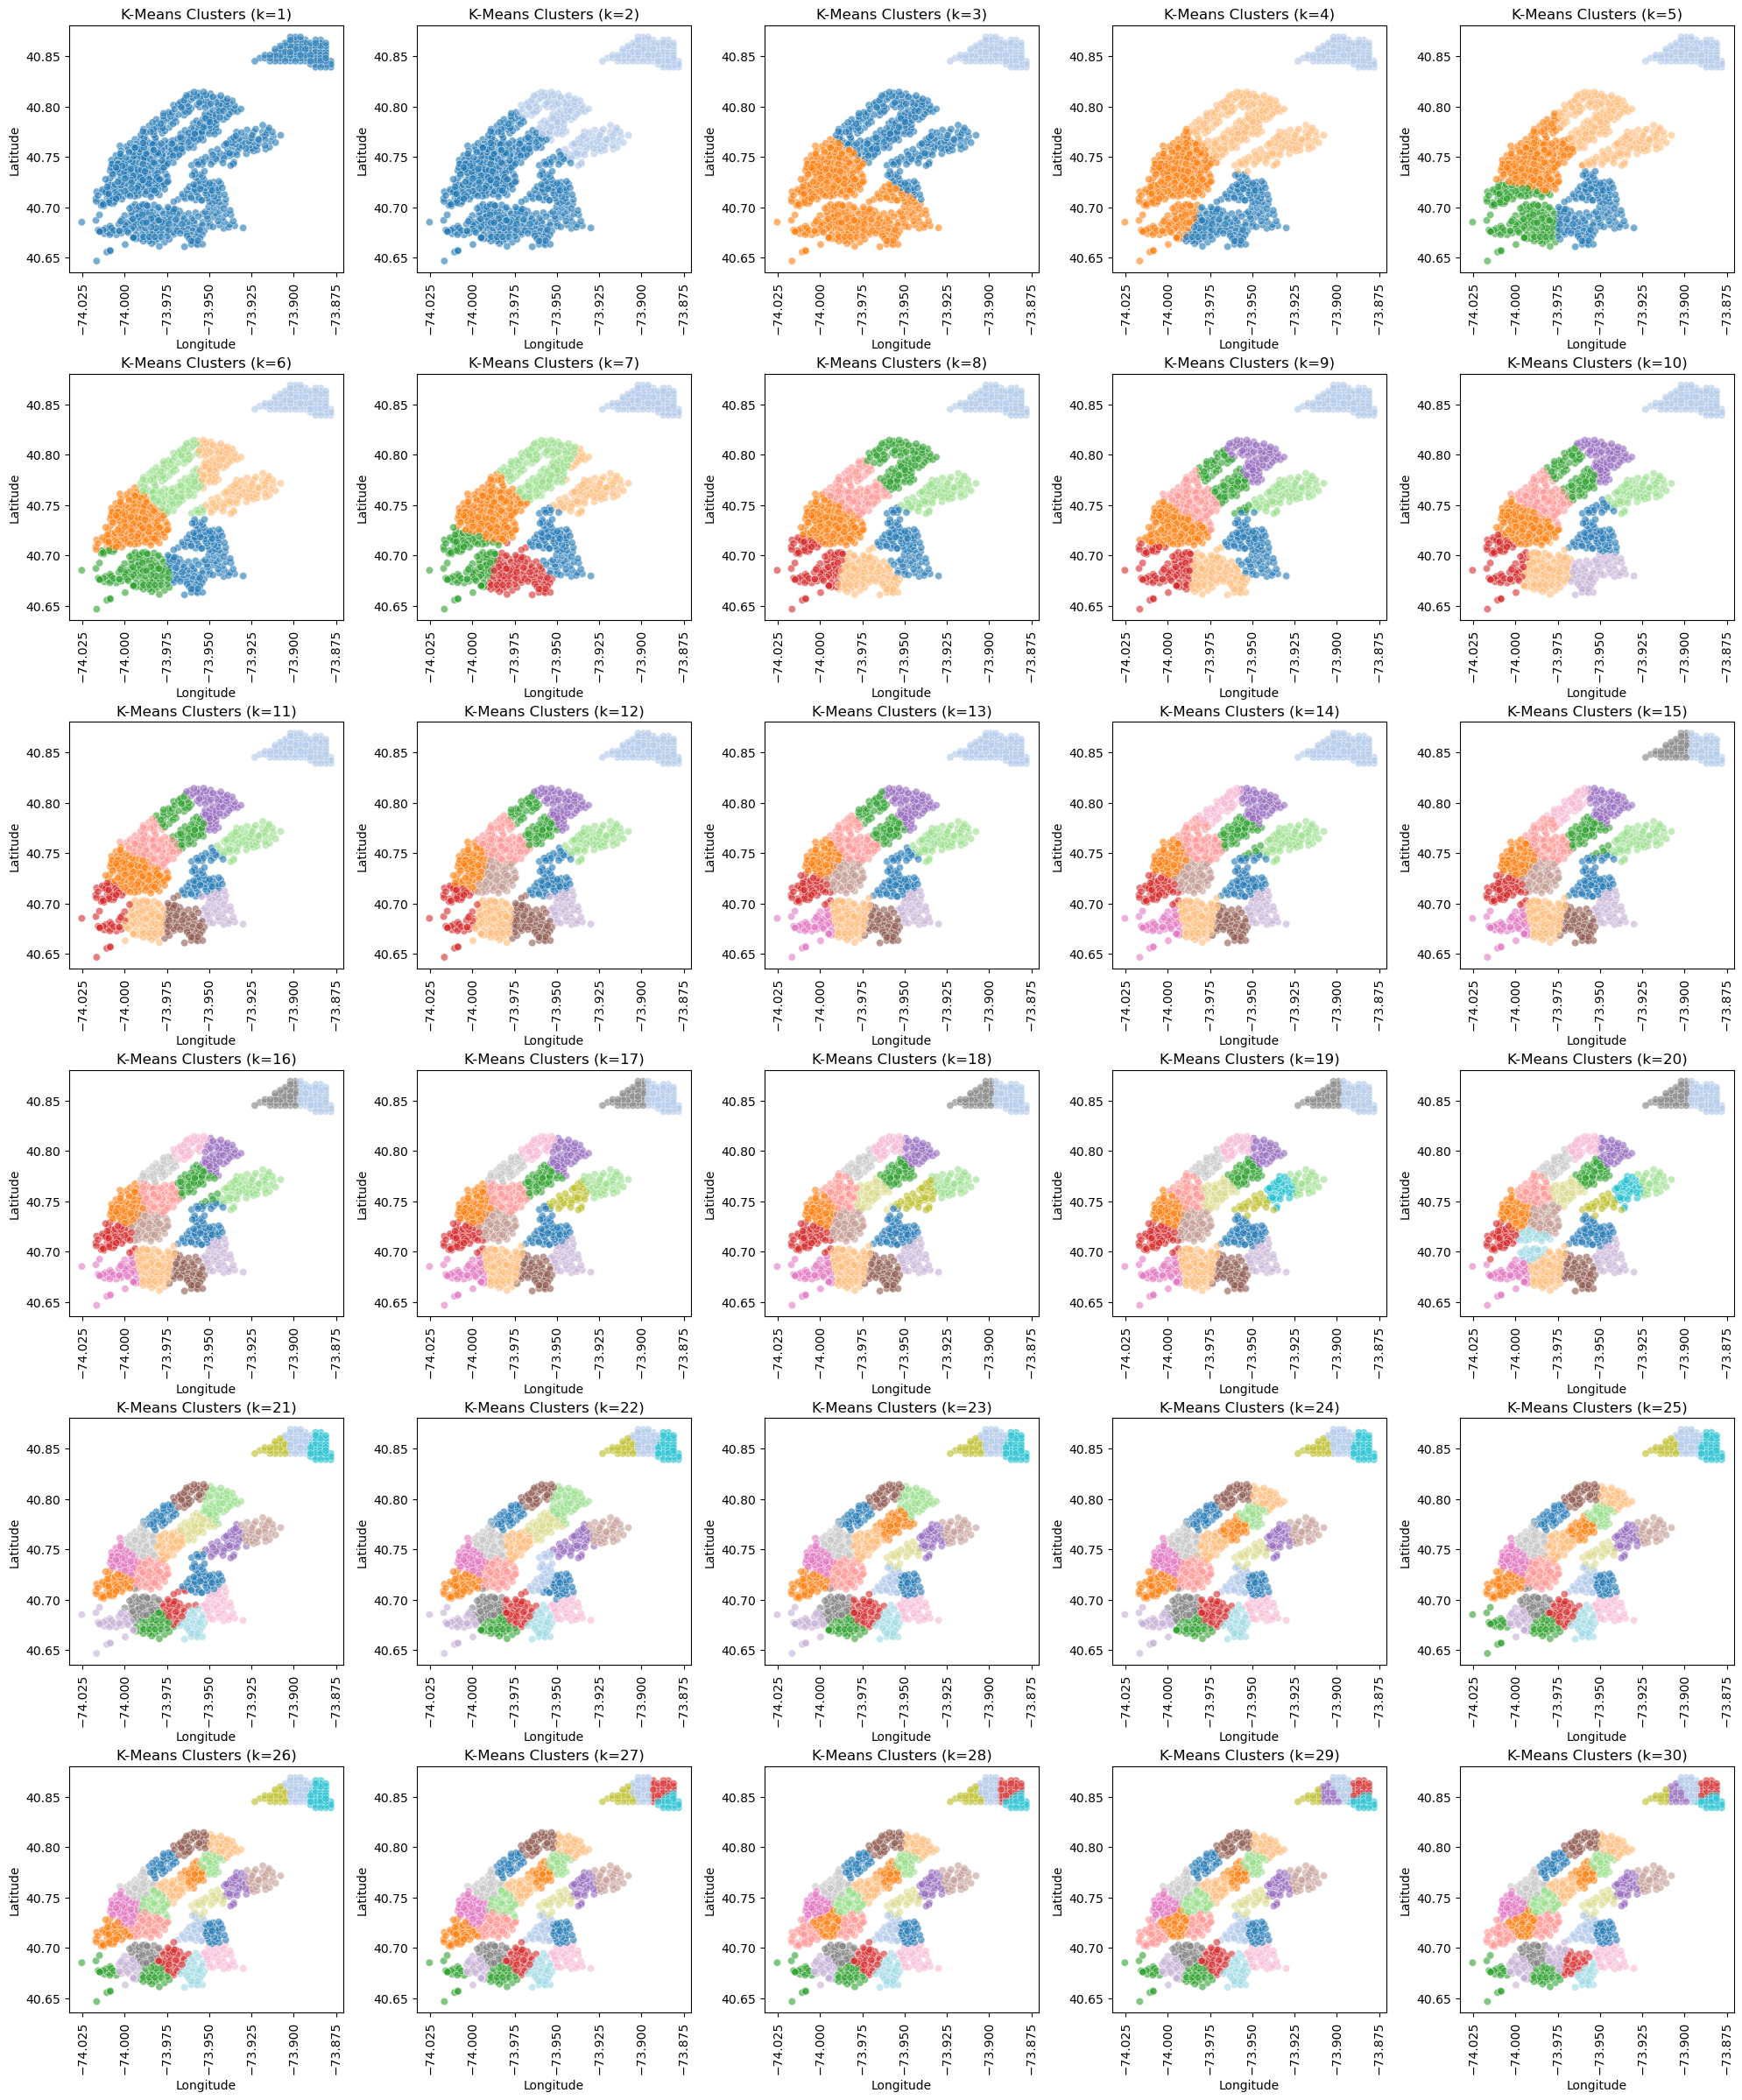

In [ ]:
# Set-up K-Means clustering for k = 1..30, to find optimal k based on eyeballing and to see how clusters evolve

# Take only lat/lon and drop missing values
coords = stations[['station_latitude', 'station_longitude']].dropna()

# Detect outliers via z-score and keep points with |z| < 3 in both dimensions
z_scores = np.abs(stats.zscore(coords))
mask_no_outliers = (z_scores < 3).all(axis=1)

# DataFrame for clustering/plotting without spatial outliers
stations_km = stations.loc[mask_no_outliers].copy()

# Standardize lat/lon (normalization to zero mean / unit variance)
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(
    stations_km[['station_latitude', 'station_longitude']]
)

# Grid of scatter plots for k = 1..30  --> 6 rows x 5 columns
fig, ax = plt.subplots(6, 5, figsize=(20, 24))  # 6x5 = 30 subplots

for n_clusters in range(1, 31):    # k = 1..30
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(coords_scaled)                    # fit on standardized data
    stations_km['station_cluster_tmp'] = kmeans.labels_

    # Row/column index in 6x5 grid (5 columns)
    r = (n_clusters - 1) // 5
    c = (n_clusters - 1) % 5

    sns.scatterplot(
        data=stations_km,
        x='station_longitude',                  # original coordinates for map
        y='station_latitude',
        hue='station_cluster_tmp',
        palette='tab20',
        legend=False,
        ax=ax[r, c],
        alpha=0.6
    )
    ax[r, c].set_title(f'K-Means Clusters (k={n_clusters})')
    ax[r, c].set_xlabel('Longitude')
    ax[r, c].set_ylabel('Latitude')

    # Rotate longitude tick labels so they don't overlap
    ax[r, c].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

# Clean up temporary column
stations_km.drop(columns=['station_cluster_tmp'], inplace=True)


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/1277095132.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')  # same palette as scatter plots


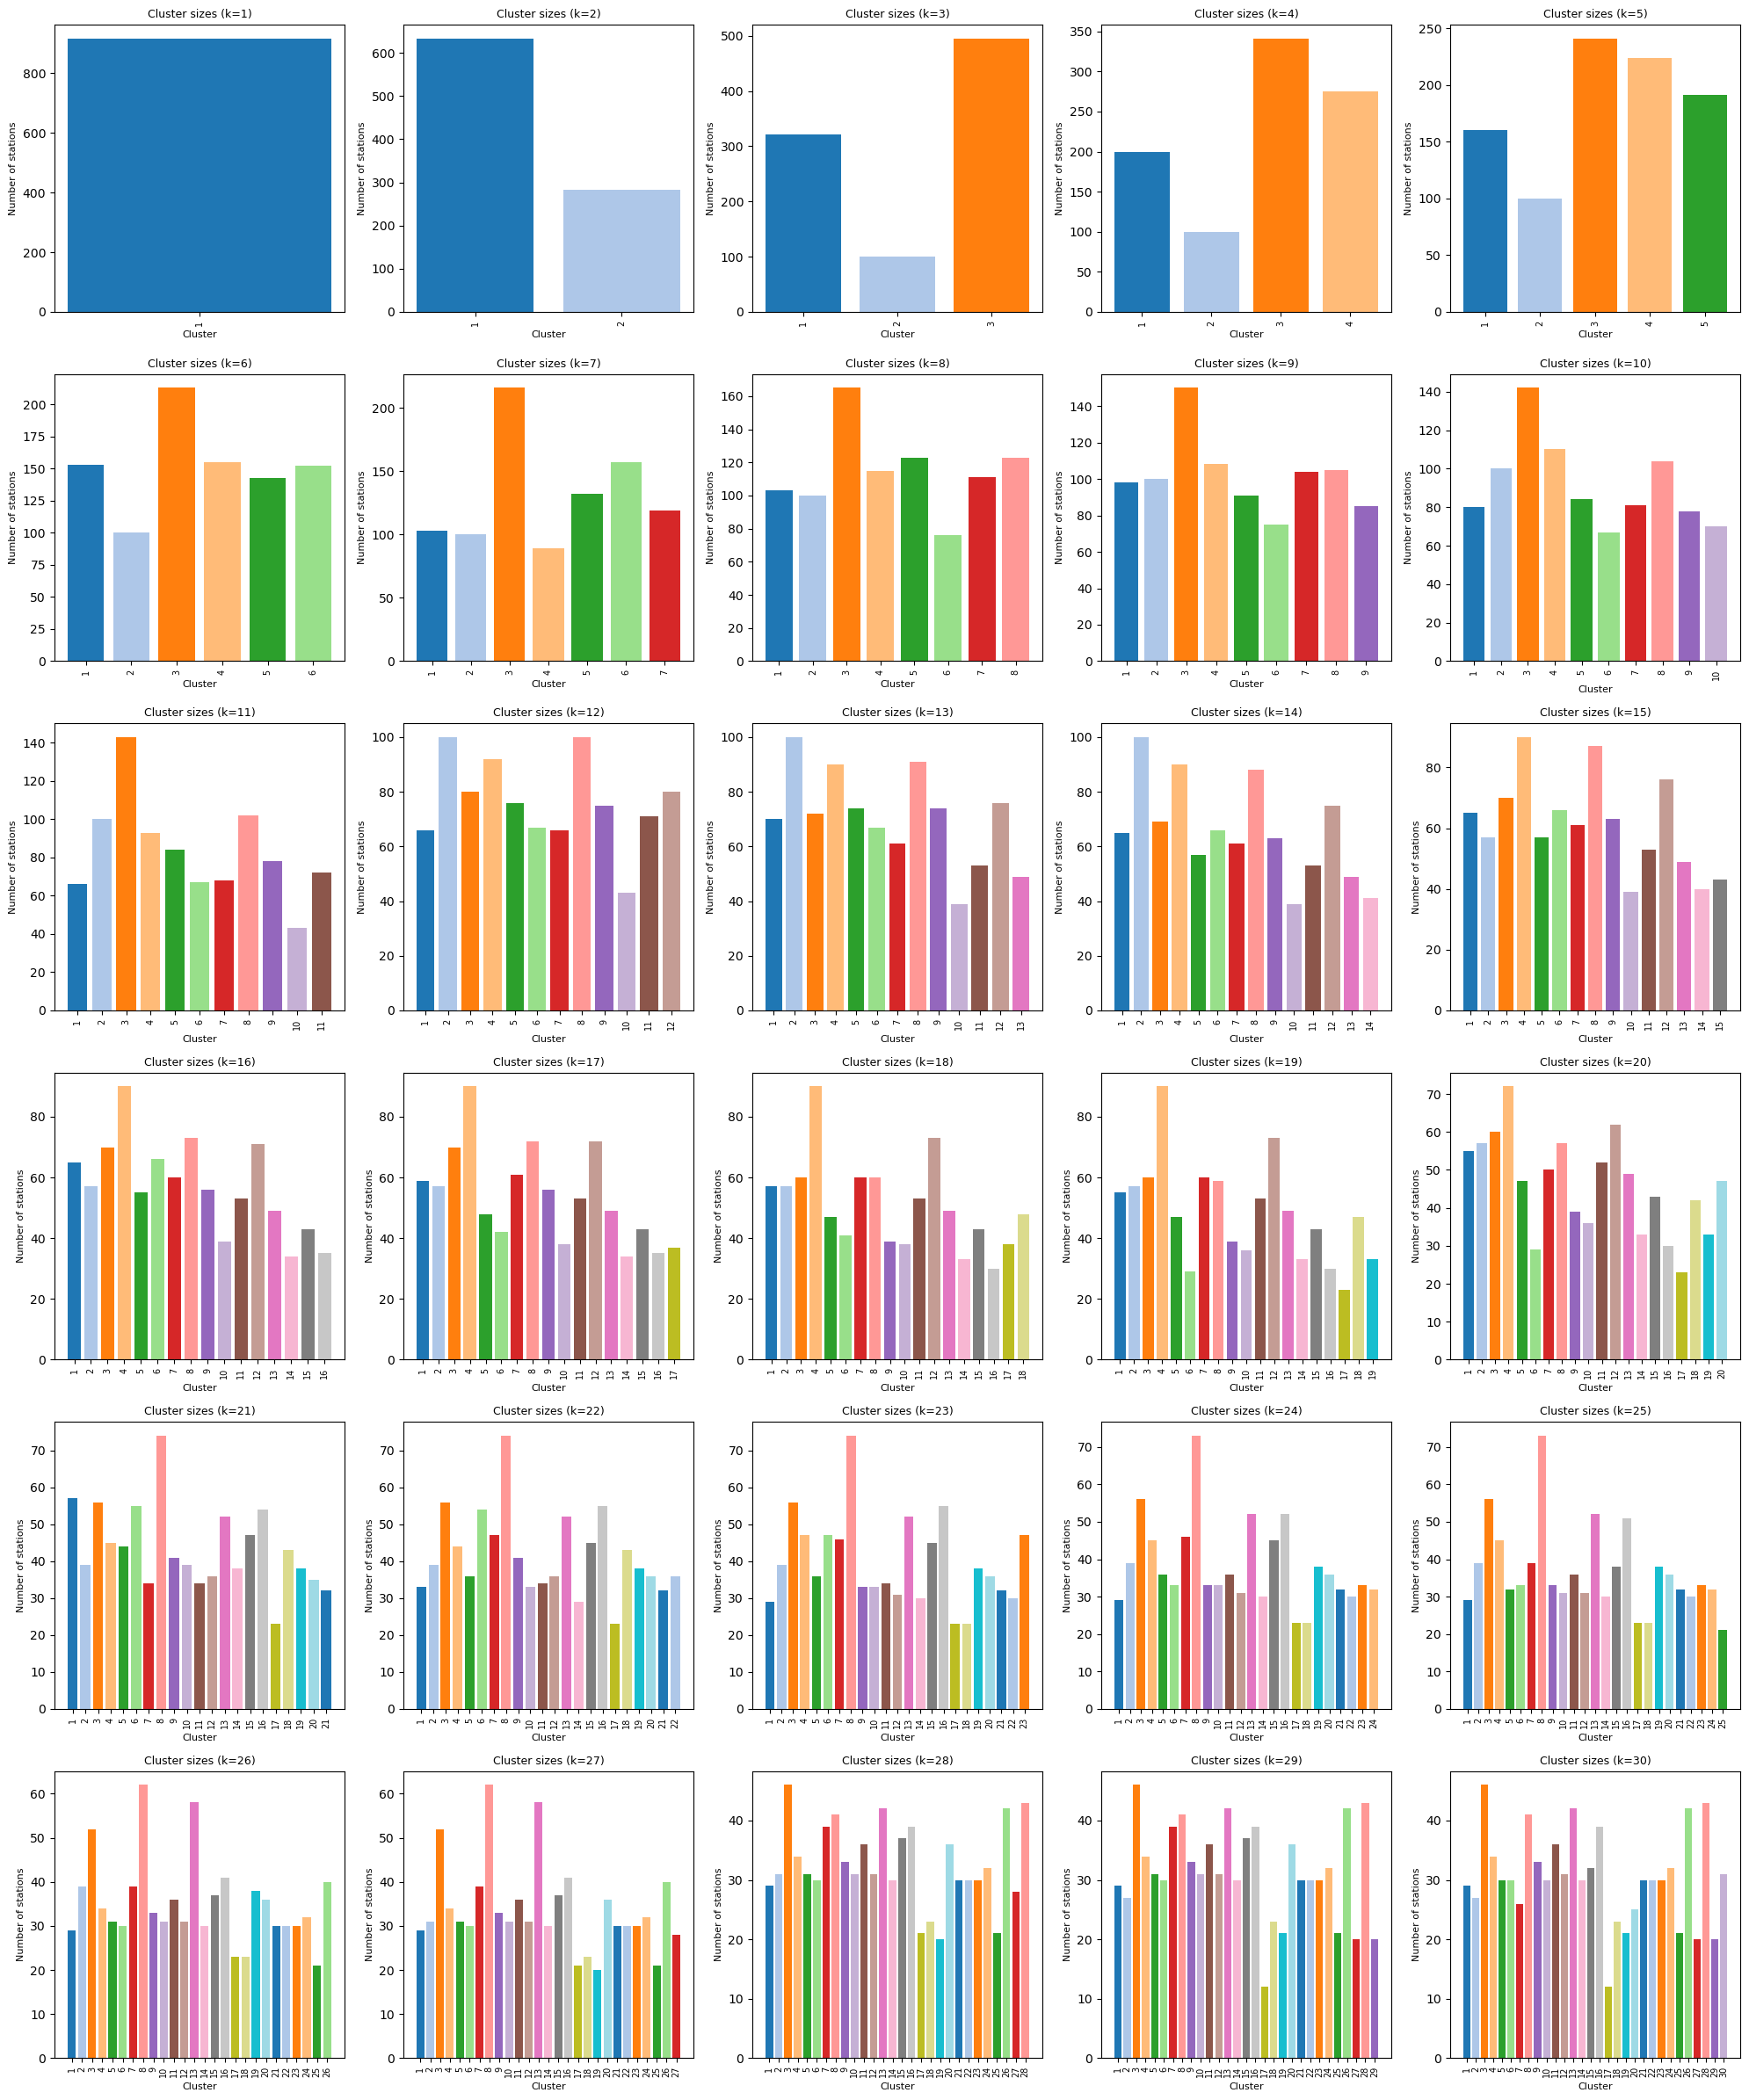

In [ ]:
# Create bar charts of cluster sizes for k = 1..30, to check, whether clusters are balanced

# Take only lat/lon and drop missing values
coords = stations[['station_latitude', 'station_longitude']].dropna()

# Remove spatial outliers (|z| < 3 in both dimensions)
z_scores = np.abs(stats.zscore(coords))
mask_no_outliers = (z_scores < 3).all(axis=1)
stations_km = stations.loc[mask_no_outliers].copy()

# Standardize lat/lon for K-Means
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(
    stations_km[['station_latitude', 'station_longitude']]
)

# Create grid of bar charts showing cluster sizes for k = 1..30
max_k = 30
fig, axes = plt.subplots(6, 5, figsize=(20, 24))  # 6x5 = 30 subplots
axes = axes.ravel()  # flatten to 1D index for convenience

cmap = plt.cm.get_cmap('tab20') 

for k in range(1, max_k + 1):
    ax = axes[k-1]

    # Fit K-Means for this k
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(coords_scaled)

    # Count stations per cluster
    cluster_sizes = np.bincount(labels, minlength=k)

    # x positions: 1..k (so first cluster is "1", not "0")
    x = np.arange(1, k + 1)

    # Colors: keep tab20, cycling if k > 20
    colors = [cmap(i % 20) for i in range(k)]

    ax.bar(x, cluster_sizes, color=colors)

    ax.set_title(f'Cluster sizes (k={k})', fontsize=9)
    ax.set_ylabel('Number of stations', fontsize=8)

    # Use cluster numbers 1..k as tick labels, rotated 90°
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in x], rotation=90, fontsize=7)
    ax.set_xlabel('Cluster', fontsize=8)

plt.tight_layout()
plt.show()


## K-Means clustering and plots

/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/339134079.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


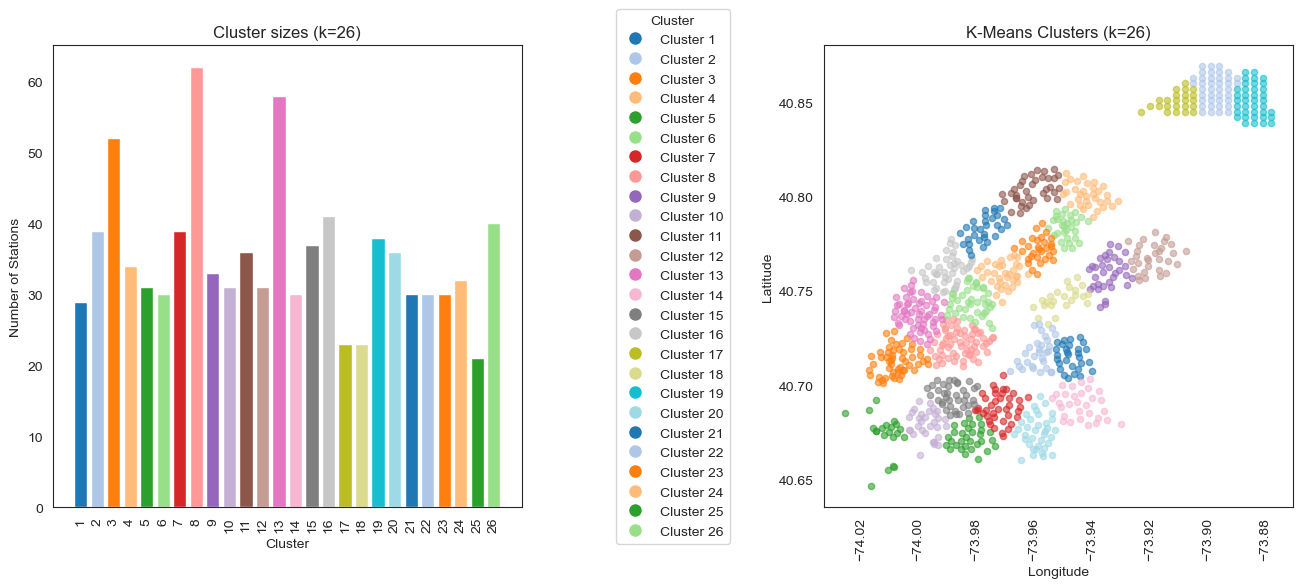

In [ ]:
# Based on eyeballing of previous plots, k = 26 seems a good choice. Visualize the k-means clusters, and the cluster sizes next to each other

k = 26

# Prepare data: remove outliers and standardize coordinates
coords = stations[['station_latitude', 'station_longitude']].dropna()
z_scores = np.abs(stats.zscore(coords))
mask_no_outliers = (z_scores < 3).all(axis=1)

stations_k26 = stations.loc[mask_no_outliers].copy()

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(
    stations_k26[['station_latitude', 'station_longitude']]
)

# Fit K-Means with k = 26
kmeans = KMeans(n_clusters=k, random_state=42)
stations_k26['cluster_k26'] = kmeans.fit_predict(coords_scaled)

# Shared color palette for all three elements
palette = sns.color_palette('tab20', k)
color_map = {c: palette[c] for c in range(k)}

# Cluster sizes for bar chart
sizes = stations_k26.groupby('cluster_k26').size().sort_index()
clusters_1based = sizes.index + 1

# Figure with three panels: bar, legend, scatter
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 0.8, 3], wspace=0.25)

ax_bar     = fig.add_subplot(gs[0, 0])  # Left  : cluster sizes
ax_legend  = fig.add_subplot(gs[0, 1])  # Middle: legend
ax_scatter = fig.add_subplot(gs[0, 2])  # Right : k-means scatter

# Left: cluster-size bar chart (same colors)
bar_colors = [color_map[c] for c in sizes.index]

ax_bar.bar(clusters_1based, sizes.values, color=bar_colors)
ax_bar.set_title(f'Cluster sizes (k={k})')
ax_bar.set_xlabel('Cluster')
ax_bar.set_ylabel('Number of Stations')

# Show every cluster label on the x-axis (1, 2, 3, ..., 26)
ax_bar.set_xticks(clusters_1based)
ax_bar.set_xticklabels([str(c) for c in clusters_1based])

for tick in ax_bar.get_xticklabels():
    tick.set_rotation(90)

# Middle: legend with round markers (keep border)
ax_legend.axis('off')

legend_handles = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=8,
        markerfacecolor=color_map[c],
        markeredgecolor=color_map[c]
    )
    for c in range(k)
]
legend_labels = [f'Cluster {c+1}' for c in range(k)]

leg = ax_legend.legend(
    legend_handles,
    legend_labels,
    title='Cluster',
    loc='center',
    frameon=True  # keep border
)
leg.get_frame().set_facecolor('white')

# Right: K-Means scatter plot
for c in range(k):
    m = stations_k26['cluster_k26'] == c
    ax_scatter.scatter(
        stations_k26.loc[m, 'station_longitude'],
        stations_k26.loc[m, 'station_latitude'],
        color=color_map[c],
        s=20,
        alpha=0.6
    )

ax_scatter.set_title(f'K-Means Clusters (k={k})')
ax_scatter.set_xlabel('Longitude')
ax_scatter.set_ylabel('Latitude')
for tick in ax_scatter.get_xticklabels():
    tick.set_rotation(90)

plt.tight_layout()
plt.show()


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/2206332269.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/2206332269.py:68: UserWarning: The palette list has more values (26) than needed (24), which may not be intended.
  sns.boxplot(
/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/2206332269.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(i + 1) for i in range(k)])


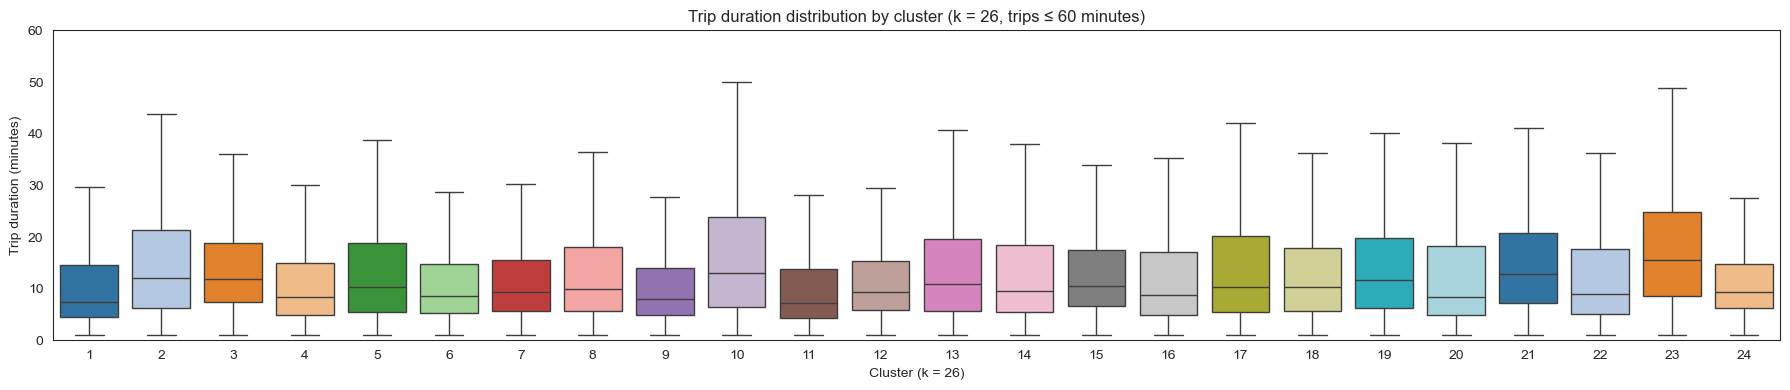

In [ ]:
# Create boxplots of trip duration by cluster for k = 26

k = 26

# Use the renamed coordinate columns
coords = stations[['station_latitude', 'station_longitude']].dropna()

# Remove spatial outliers (|z| < 3 on both dimensions)
z_scores = np.abs(stats.zscore(coords))
mask_no_outliers = (z_scores < 3).all(axis=1)

stations_k26 = stations.loc[mask_no_outliers].copy()

# Standardize lat/lon
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(
    stations_k26[['station_latitude', 'station_longitude']]
)

# Fit K-Means
kmeans = KMeans(n_clusters=k, random_state=42)
stations_k26['cluster_k26'] = kmeans.fit_predict(coords_scaled)

# Map each start_station_id to a unique cluster (one row per station)
cluster_map_26 = (
    stations_k26
    .drop_duplicates('start_station_id')
    .set_index('start_station_id')['cluster_k26']
)

# Attach cluster labels to trips and compute trip duration in minutes

data_k26 = data.copy()

# add cluster_k26 to each trip based on its start_station_id
data_k26['cluster_k26'] = data_k26['start_station_id'].map(cluster_map_26)

# drop trips whose start station was removed as an outlier
data_k26 = data_k26.dropna(subset=['cluster_k26']).copy()
data_k26['cluster_k26'] = data_k26['cluster_k26'].astype(int)   # 0..25

# trip duration in minutes
data_k26['tripduration_min'] = data_k26['tripduration'] / 60.0

# Filter to trips <= 60 minutes, to capture the main distribution without extreme outliers

cutoff = 60  # minutes
df_box = data_k26[data_k26['tripduration_min'] <= cutoff].copy()

# Boxplots with the same colors as in the cluster-size / scatter fig

palette = sns.color_palette('tab20', k)   # palette[0] is cluster 0, ..., palette[25] is cluster 25

plt.figure(figsize=(18, 4))

sns.boxplot(
    x='cluster_k26',
    y='tripduration_min',
    data=df_box,
    order=sorted(df_box['cluster_k26'].unique()),  # ensure clusters 0..25 in order
    palette=palette,       # use the same 26 colors in the same order
    showfliers=False       # do not draw points beyond the whiskers
)

plt.xlabel('Cluster (k = 26)')
plt.ylabel('Trip duration (minutes)')
plt.title(f'Trip duration distribution by cluster (k = 26, trips ≤ {cutoff} minutes)')

# y-axis from 0 to 60 and show tick at 60
plt.ylim(0, cutoff)
plt.yticks(np.arange(0, cutoff + 1, 10))   # ticks at 0, 10, ..., 60

# Show cluster labels as 1..26 instead of 0..25 on the axis
ax = plt.gca()
ax.set_xticklabels([str(i + 1) for i in range(k)])

plt.tight_layout()
plt.show()


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/2313632900.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/2313632900.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(c + 1) for c in present_clusters])


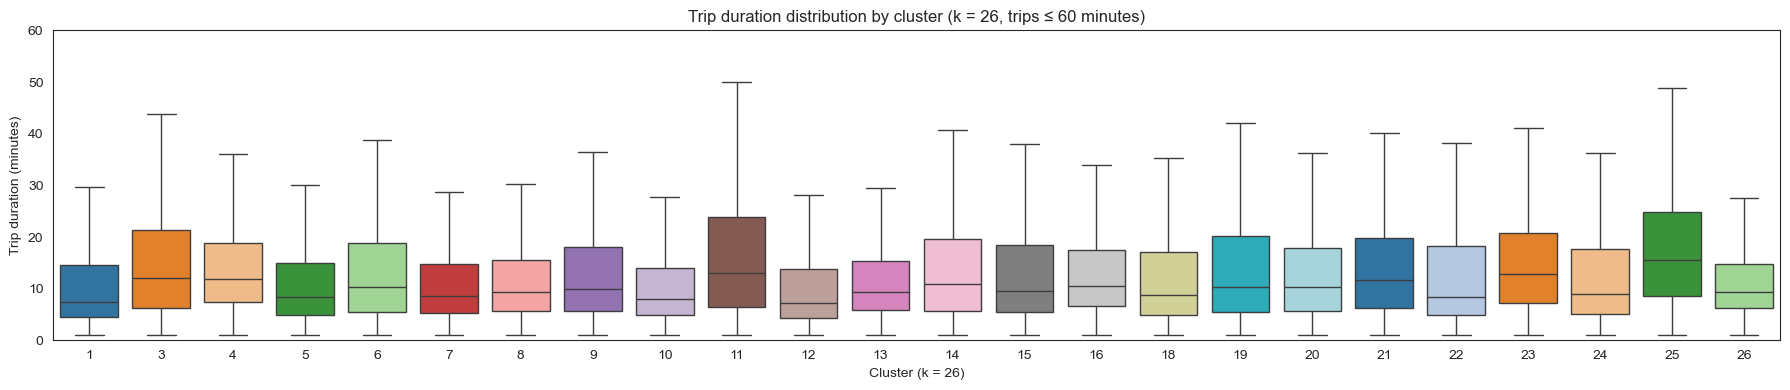

In [ ]:
# --- IMPORTANT NOTE ABOUT "MISSING" CLUSTERS ---------------------------------
# After the steps above, some clusters (e.g. 2 or 17) can end up with **no trips**
# in data_k26 for the following reasons:
#   1) All stations that originally belonged to that cluster were removed as
#      spatial outliers before clustering or mapping.
#   2) Those stations do exist, but all trips starting from them have a trip
#      duration > cutoff (60 minutes in our case) and are filtered out below.
# Seaborn’s boxplot only draws boxes for categories that actually have data
# points in the DataFrame. If a cluster has zero remaining rows after filtering,
# it simply doesn’t appear in the plot.

# K-means clustering with k = 26 on station coordinates
k = 26

coords = stations[['station_latitude', 'station_longitude']].dropna()

# Remove spatial outliers (|z| < 3 on both dimensions)
z_scores = np.abs(stats.zscore(coords))
mask_no_outliers = (z_scores < 3).all(axis=1)
stations_k26 = stations.loc[mask_no_outliers].copy()

# Standardize lat/lon and fit K-Means
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(
    stations_k26[['station_latitude', 'station_longitude']]
)
kmeans = KMeans(n_clusters=k, random_state=42)
stations_k26['cluster_k26'] = kmeans.fit_predict(coords_scaled)

# Shared color palette, identical to your combined figure
palette = sns.color_palette('tab20', k)
color_map = {c: palette[c] for c in range(k)}   # 0..25 -> color

# Map each start_station_id to a unique cluster
cluster_map_26 = (
    stations_k26
    .drop_duplicates('start_station_id')
    .set_index('start_station_id')['cluster_k26']
)

# Attach cluster labels to trips and compute duration in minutes
data_k26 = data.copy()
data_k26['cluster_k26'] = data_k26['start_station_id'].map(cluster_map_26)

# Drop trips whose start station was removed as an outlier
data_k26 = data_k26.dropna(subset=['cluster_k26']).copy()
data_k26['cluster_k26'] = data_k26['cluster_k26'].astype(int)

data_k26['tripduration_min'] = data_k26['tripduration'] / 60.0

# Filter to trips <= 60 minutes, to capture the main distribution without extreme outliers
cutoff = 60
df_box = data_k26[data_k26['tripduration_min'] <= cutoff].copy()

# Clusters that actually have data after the cutoff (0-based ids)
present_clusters = sorted(df_box['cluster_k26'].unique())

# Colors in the same order as the clusters we are plotting
box_colors = [color_map[c] for c in present_clusters]

plt.figure(figsize=(18, 4))
ax = sns.boxplot(
    x='cluster_k26',
    y='tripduration_min',
    data=df_box,
    order=present_clusters,   # only these clusters appear (2,17 omitted if empty)
    palette=box_colors,       # same colors as bar+scatter, aligned with order
    showfliers=False          # do not draw individual outlier points
)

plt.xlabel('Cluster (k = 26)')
plt.ylabel('Trip duration (minutes)')
plt.title(f'Trip duration distribution by cluster (k = 26, trips ≤ {cutoff} minutes)')

# y-axis from 0 to 60 with tick at 60
plt.ylim(0, cutoff)
plt.yticks(np.arange(0, cutoff + 1, 10))

# Relabel x-axis from 0-based IDs to 1..26
ax.set_xticklabels([str(c + 1) for c in present_clusters])

plt.tight_layout()
plt.show()


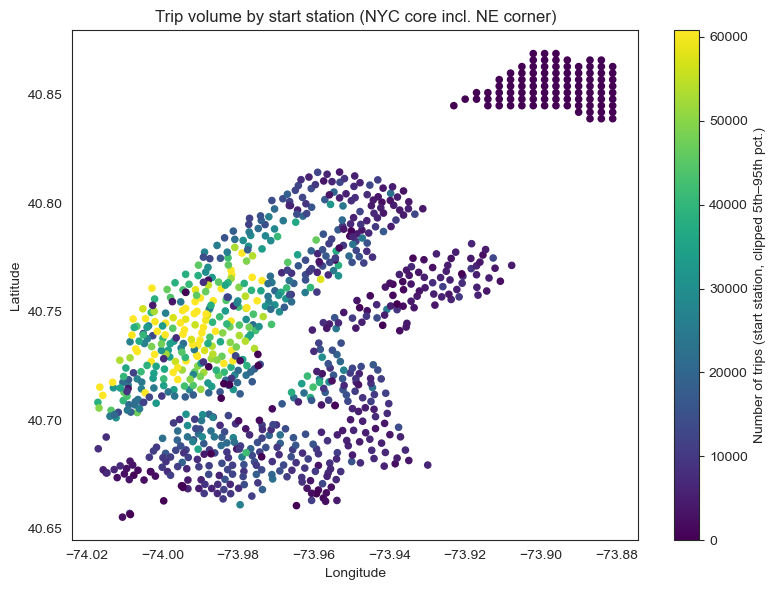

In [ ]:
# Creating a scatter plot of trip volumes by start station, coloured by number of trips
# Trips per start station

trips_per_station = (
    data
    .groupby('start_station_id')
    .size()
    .reset_index(name='num_trips')
)

# Join with station coordinates

stations_vol = (
    stations
    .merge(trips_per_station, on='start_station_id', how='left')
    .fillna({'num_trips': 0})
)

# Keep NYC core including the NE corner
# Same bounds as in the other plots: Manhattan + NE cluster, but no far outliers.

core_mask = (
    stations_vol['station_latitude'].between(40.65, 40.87) &
    stations_vol['station_longitude'].between(-74.02, -73.88)
)

stations_vol_core = stations_vol[core_mask].copy()

# Clip colour scale so a few huge stations don't dominate

low, high = stations_vol_core['num_trips'].quantile([0.05, 0.95])
stations_vol_core['num_trips_clipped'] = stations_vol_core['num_trips'].clip(low, high)

# Plot

plt.figure(figsize=(8, 6))

sc = plt.scatter(
    stations_vol_core['station_longitude'],
    stations_vol_core['station_latitude'],
    c=stations_vol_core['num_trips_clipped'],   # clipped volumes for colour
    s=20,
    cmap='viridis'
)

cbar = plt.colorbar(sc)
cbar.set_label('Number of trips (start station, clipped 5th–95th pct.)')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trip volume by start station (NYC core incl. NE corner)')
plt.tight_layout()
plt.show()


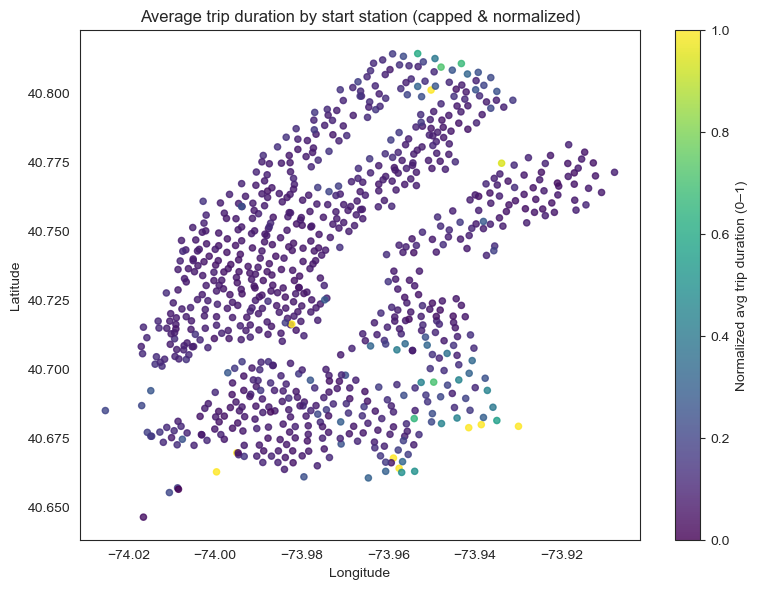

In [ ]:
# Creating a scatter plot of average trip duration by start station, coloured by average duration

# Remove spatial outlier stations
# We assume `stations` has one row per station with lat/lon (NYC + that far-away station)
coords = stations[['station_latitude', 'station_longitude']].dropna()

# z-score filter: keep stations where both lat & lon are within |z| < 3
z_scores = np.abs(stats.zscore(coords))
mask_geo = (z_scores < 3).all(axis=1)

stations_clean = stations.loc[mask_geo].copy()

# Compute average trip duration per start station
# Merge trips with station coordinates (only for stations that passed the geo filter)
data_geo = data.merge(
    stations_clean[['start_station_id', 'station_latitude', 'station_longitude']],
    on='start_station_id',
    how='inner'
)

# Trip duration in minutes
data_geo['tripduration_min'] = data_geo['tripduration'] / 60.0

# Average trip duration per start station
avg_by_station = (
    data_geo
    .groupby(['start_station_id', 'station_latitude', 'station_longitude'])['tripduration_min']
    .mean()
    .reset_index(name='avg_tripduration_min')
)

# Cap extreme values (e.g. 99th percentile) so outliers don't dominate the color scale after normalization
q99 = avg_by_station['avg_tripduration_min'].quantile(0.99)

# Clip values above the 99th percentile
avg_by_station['avg_tripduration_capped'] = avg_by_station['avg_tripduration_min'].clip(upper=q99)


# Min–max normalize the *capped* average durations to [0, 1]
scaler = MinMaxScaler()
avg_by_station['avg_tripduration_norm'] = scaler.fit_transform(
    avg_by_station[['avg_tripduration_capped']]
)

# Plot: normalized average trip duration vs. longitude/latitude
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    avg_by_station['station_longitude'],
    avg_by_station['station_latitude'],
    c=avg_by_station['avg_tripduration_norm'],
    cmap='viridis',
    s=20,
    alpha=0.8
)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Average trip duration by start station (capped & normalized)')

cbar = plt.colorbar(scatter)
cbar.set_label('Normalized avg trip duration (0–1)')

plt.tight_layout()
plt.show()


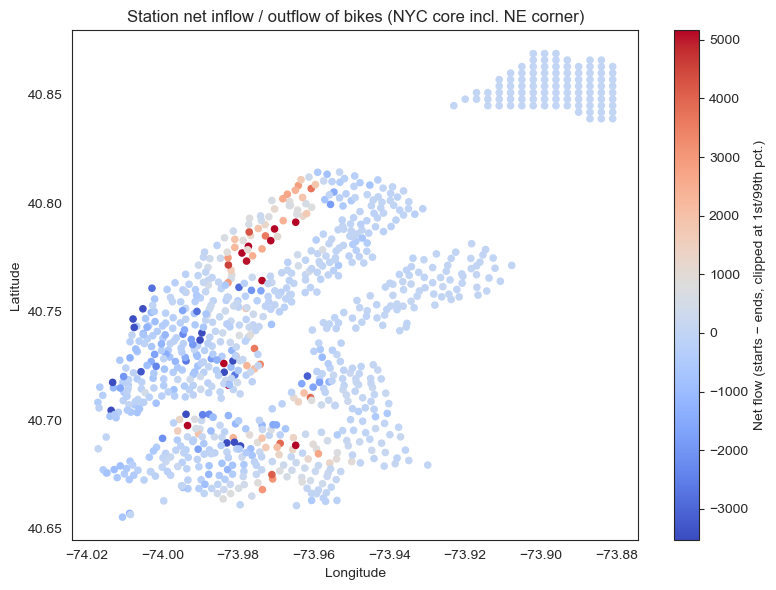

In [ ]:
# Creating a scatter plot of station net inflow / outflow of bikes

# Trips starting / ending at each station
starts = (
    data
    .groupby('start_station_id')
    .size()
    .rename('num_starts')
)

ends = (
    data
    .groupby('end_station_id')
    .size()
    .rename('num_ends')
)

balance = (
    stations
    .set_index('start_station_id')
    .join(starts)
    .join(ends, how='left')
    .fillna({'num_starts': 0, 'num_ends': 0})
)

balance['net_flow'] = balance['num_starts'] - balance['num_ends']

# Lat ~40.65–40.87 includes Manhattan + NE cluster but excludes the far 45° outlier
# Lon ~-74.02–-73.88 keeps the core and the NE cluster, but drops the distant station.

core_mask = (
    (balance['station_latitude'].between(40.65, 40.87)) &
    (balance['station_longitude'].between(-74.02, -73.88))
)

balance_core = balance[core_mask].copy()

# Clip colour scale to tame extreme net flows

low, high = balance_core['net_flow'].quantile([0.01, 0.99])
balance_core['net_flow_clipped'] = balance_core['net_flow'].clip(low, high)

# Plot

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    balance_core['station_longitude'],
    balance_core['station_latitude'],
    c=balance_core['net_flow_clipped'],
    s=20,
    cmap='coolwarm'
)

cbar = plt.colorbar(sc)
cbar.set_label('Net flow (starts − ends, clipped at 1st/99th pct.)')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Station net inflow / outflow of bikes (NYC core incl. NE corner)')

plt.tight_layout()
plt.show()



# Red / orange stations → net_flow > 0 → more starts than ends
# These are net exporters of bikes (bikes tend to leave from here and end elsewhere).
# Blue stations → net_flow < 0 → more ends than starts
# These are net importers of bikes (bikes tend to arrive here and start elsewhere).
# Grey / neutral stations → net_flow ≈ 0 → starts and ends are roughly balanced.
# Because we clipped extreme values at the 1st / 99th percentile, the color scale is dominated by “normal” stations and not by a few huge outliers.

Correlation between hour of day and avg rentals: 0.498


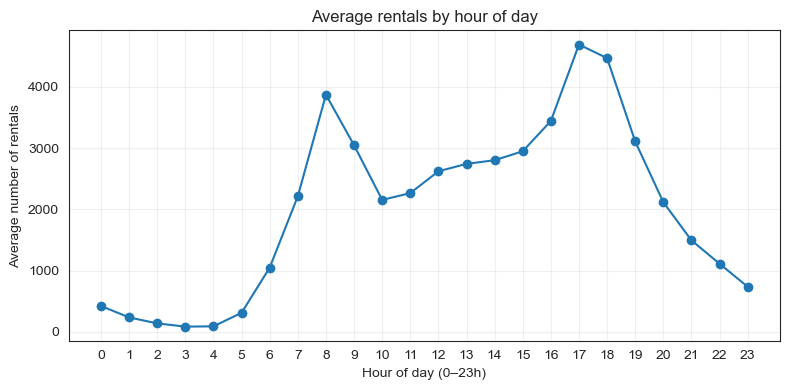

In [206]:
# If not already done: create pickup_datetime, pickup_day and pickup_hour from starttime
data['pickup_datetime'] = pd.to_datetime(data['starttime'])
data['pickup_day'] = data['pickup_datetime'].dt.date
data['pickup_hour'] = data['pickup_datetime'].dt.hour  # 0..23

# Average rentals per hour over days (per day+hour slot)
bikes_per_slot = (
    data
    .groupby(['pickup_day', 'pickup_hour'])
    .size()
    .reset_index(name='num_rentals')
)

avg_per_hour = (
    bikes_per_slot
    .groupby('pickup_hour')['num_rentals']
    .mean()
    .reset_index(name='avg_num_rentals')
)

# 2) Correlation between hour of day and average rentals
corr = avg_per_hour['pickup_hour'].corr(avg_per_hour['avg_num_rentals'])
print(f"Correlation between hour of day and avg rentals: {corr:.3f}")

# 3) Plot: hour-of-day vs. average rentals
plt.figure(figsize=(8, 4))
plt.plot(
    avg_per_hour['pickup_hour'],
    avg_per_hour['avg_num_rentals'],
    marker='o'
)
plt.xticks(range(0, 24))  # show all hours 0..23
plt.xlabel('Hour of day (0–23h)')
plt.ylabel('Average number of rentals')
plt.title('Average rentals by hour of day')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


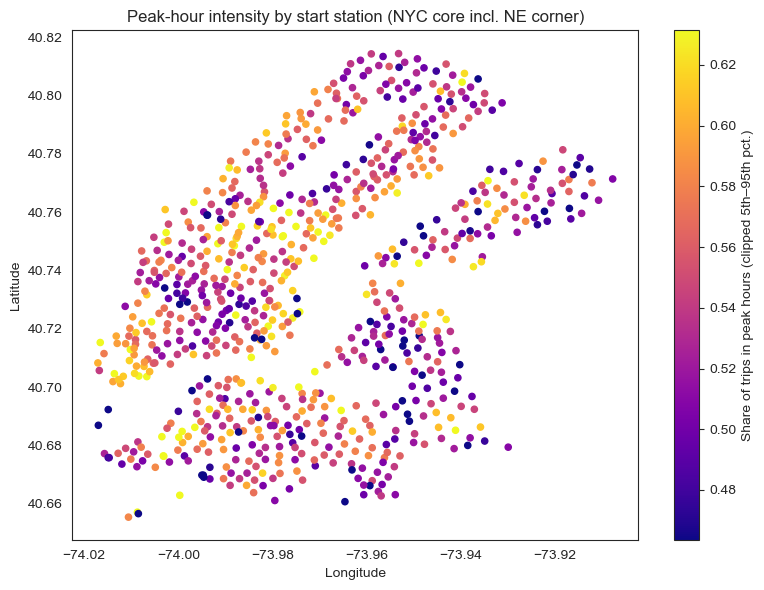

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Prepare datetime + hour ----------------------------------------------

data['pickup_datetime'] = pd.to_datetime(data['starttime'])
data['pickup_hour'] = data['pickup_datetime'].dt.hour  # 0..23

# --- 2. Define peak hours (you can change these ranges if you want) ----------

# Morning 7–10 and evening 16–19 (inclusive)
peak_mask = (
    data['pickup_hour'].between(7, 10) |    # 7, 8, 9, 10
    data['pickup_hour'].between(16, 19)     # 16, 17, 18, 19
)

# --- 3. Count total vs. peak trips per start station -------------------------

total_by_station = (
    data
    .groupby('start_station_id')
    .size()
    .rename('total_trips')
)

peak_by_station = (
    data[peak_mask]
    .groupby('start_station_id')
    .size()
    .rename('peak_trips')
)

# Join counts back to the stations table
peak_share = (
    stations
    .set_index('start_station_id')
    .join(total_by_station)
    .join(peak_by_station, how='left')
    .fillna({'total_trips': 0, 'peak_trips': 0})
)

# Keep only stations that actually have trips
peak_share = peak_share[peak_share['total_trips'] > 0].copy()

# Share of trips that occur in peak hours (0–1)
peak_share['peak_share'] = peak_share['peak_trips'] / peak_share['total_trips']

# --- 4. Apply the SAME spatial filter as the net-flow plot -------------------
# This keeps the NYC core *including* the NE corner and removes the far outlier.

core_mask = (
    peak_share['station_latitude'].between(40.65, 40.87) &   # same as net-flow code
    peak_share['station_longitude'].between(-74.02, -73.88)  # same as net-flow code
)

peak_share_core = peak_share[core_mask].copy()

# --- 5. Clip colour scale so outliers don't dominate -------------------------

low, high = peak_share_core['peak_share'].quantile([0.05, 0.95])
peak_share_core['peak_share_clipped'] = peak_share_core['peak_share'].clip(low, high)

# (Previously the KeyError happened because this column didn't exist yet.)

# --- 6. Plot peak-hour intensity (NE corner now included) --------------------

plt.figure(figsize=(8, 6))

sc = plt.scatter(
    peak_share_core['station_longitude'],
    peak_share_core['station_latitude'],
    c=peak_share_core['peak_share_clipped'],   # clipped values for nicer colour scale
    s=20,
    cmap='plasma'
)

cbar = plt.colorbar(sc)
cbar.set_label('Share of trips in peak hours (clipped 5th–95th pct.)')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Peak-hour intensity by start station (NYC core incl. NE corner)')

plt.tight_layout()
plt.show()


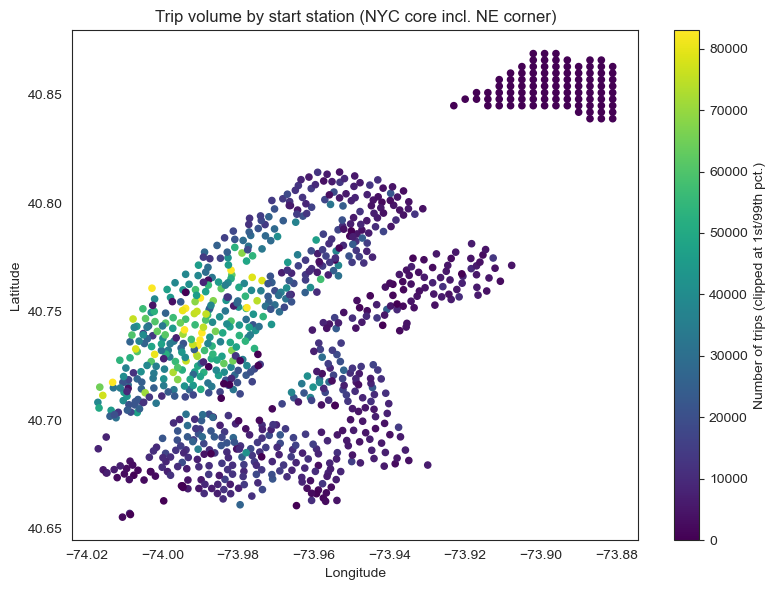

In [227]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Trips per start station
trips_per_station = (
    data
    .groupby('start_station_id')
    .size()
    .reset_index(name='num_trips')
)

# 2) Join with station coordinates
stations_vol = stations.merge(
    trips_per_station,
    on='start_station_id',
    how='left'
).fillna({'num_trips': 0})

# 3) Keep NYC core INCLUDING the NE corner, drop far-away outliers
core_mask = (
    stations_vol['station_latitude'].between(40.65, 40.87) &
    stations_vol['station_longitude'].between(-74.02, -73.88)
)
stations_vol_core = stations_vol[core_mask].copy()

# 4) Clip colours so a few extreme high-volume stations don’t dominate
low, high = stations_vol_core['num_trips'].quantile([0.01, 0.99])
stations_vol_core['num_trips_clipped'] = stations_vol_core['num_trips'].clip(low, high)

# 5) Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    stations_vol_core['station_longitude'],
    stations_vol_core['station_latitude'],
    c=stations_vol_core['num_trips_clipped'],
    s=20,
    cmap='viridis'
)
cbar = plt.colorbar(sc)
cbar.set_label('Number of trips (clipped at 1st/99th pct.)')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trip volume by start station (NYC core incl. NE corner)')
plt.tight_layout()
plt.show()


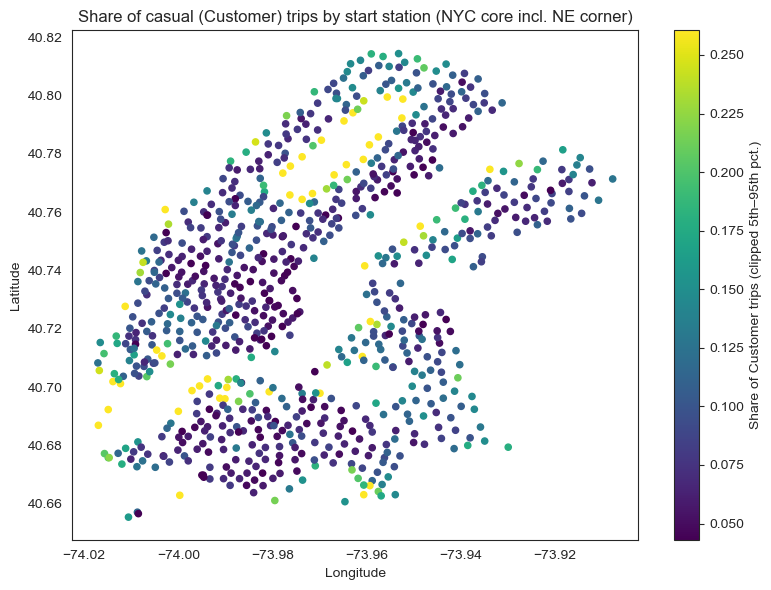

In [229]:
import matplotlib.pyplot as plt

# --- 1. Share of 'Customer' trips per station -------------------------------
user_counts = (
    data
    .groupby(['start_station_id', 'usertype'])
    .size()
    .unstack(fill_value=0)
)

user_counts['total'] = user_counts.sum(axis=1)
user_counts['customer_share'] = user_counts.get('Customer', 0) / user_counts['total']

user_spatial = (
    stations
    .set_index('start_station_id')
    .join(user_counts[['customer_share']], how='inner')
)

# --- 2. NYC core incl. NE corner --------------------------------------------
core_mask = (
    user_spatial['station_latitude'].between(40.65, 40.87) &
    user_spatial['station_longitude'].between(-74.02, -73.88)
)
user_spatial_core = user_spatial[core_mask].copy()

# --- 3. Clip colour scale (5th–95th percentile of share) --------------------
low, high = user_spatial_core['customer_share'].quantile([0.05, 0.95])
user_spatial_core['customer_share_clipped'] = user_spatial_core['customer_share'].clip(low, high)

# --- 4. Plot -----------------------------------------------------------------
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    user_spatial_core['station_longitude'],
    user_spatial_core['station_latitude'],
    c=user_spatial_core['customer_share_clipped'],
    s=20,
    cmap='viridis'
)
plt.colorbar(sc, label='Share of Customer trips (clipped 5th–95th pct.)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Share of casual (Customer) trips by start station (NYC core incl. NE corner)')
plt.tight_layout()
plt.show()


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/1943082625.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


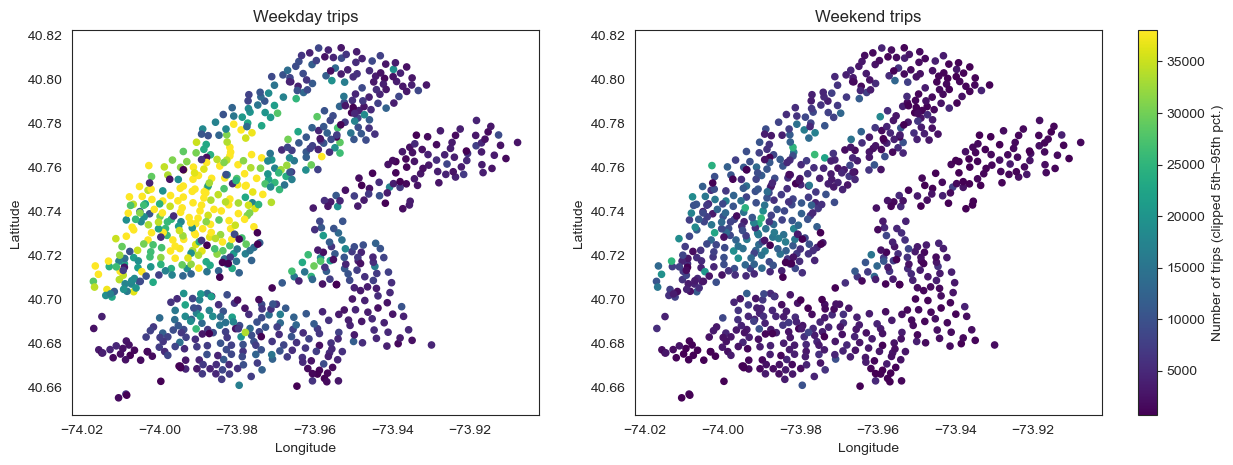

In [249]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1) Weekday / weekend flag ----------------------------------------------
data['pickup_datetime'] = pd.to_datetime(data['starttime'])
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday  # 0 = Mon, 6 = Sun
data['is_weekend'] = data['pickup_weekday'] >= 5

# --- 2) Aggregate trips per station & weekend flag --------------------------
station_week = (
    data
    .groupby(['start_station_id', 'is_weekend'])
    .size()
    .reset_index(name='num_trips')
    .pivot(index='start_station_id', columns='is_weekend', values='num_trips')
    .fillna(0)
    .rename(columns={False: 'weekday_trips', True: 'weekend_trips'})
)

station_week = stations.set_index('start_station_id').join(station_week, how='inner')

# --- 3) Keep NYC core incl. NE corner, drop distant outlier -----------------
core_mask = (
    station_week['station_latitude'].between(40.65, 40.87) &
    station_week['station_longitude'].between(-74.02, -73.88)
)
station_week_core = station_week[core_mask].copy()

# --- 4) Clip colour scale (5th–95th percentile across both weekday+weekend) --
all_vals = station_week_core[['weekday_trips', 'weekend_trips']].stack()
low, high = all_vals.quantile([0.05, 0.95])

station_week_core['weekday_trips_clip'] = station_week_core['weekday_trips'].clip(low, high)
station_week_core['weekend_trips_clip'] = station_week_core['weekend_trips'].clip(low, high)

# --- 5) Plot: 2 subplots + separate colorbar axis ---------------------------
# Layout: [ weekday | spacer | weekend | colorbar ]
fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(
    1, 4,
    width_ratios=[1.0, 0.05, 1.0, 0.04],  # small empty spacer between the two maps
    wspace=0.15
)

ax_wd = fig.add_subplot(gs[0, 0])  # left: weekday
ax_we = fig.add_subplot(gs[0, 2])  # right: weekend (shifted slightly right)
cax   = fig.add_subplot(gs[0, 3])  # thin colorbar on the far right

scatter_kwargs = dict(
    s=20,
    cmap='viridis',
    vmin=low,
    vmax=high,
)

# Weekday trips
sc1 = ax_wd.scatter(
    station_week_core['station_longitude'],
    station_week_core['station_latitude'],
    c=station_week_core['weekday_trips_clip'],
    **scatter_kwargs
)
ax_wd.set_title('Weekday trips')
ax_wd.set_xlabel('Longitude')
ax_wd.set_ylabel('Latitude')

# Weekend trips (same data extent, just placed in the shifted axis)
sc2 = ax_we.scatter(
    station_week_core['station_longitude'],
    station_week_core['station_latitude'],
    c=station_week_core['weekend_trips_clip'],
    **scatter_kwargs
)
ax_we.set_title('Weekend trips')
ax_we.set_xlabel('Longitude')
ax_we.set_ylabel('Latitude')

# Shared colorbar, close to weekend plot but not overlapping
cbar = fig.colorbar(sc2, cax=cax)
cbar.set_label('Number of trips (clipped 5th–95th pct.)')

plt.tight_layout()
plt.show()


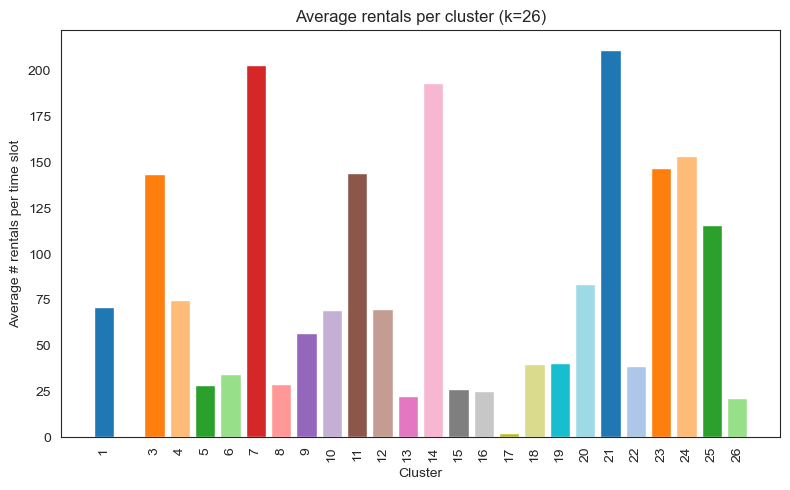

In [141]:
# --- 11. BAR CHART: AVG RENTALS PER CLUSTER (k = 26) ------------------------
# k = 26, palette as before
k = 26
palette = sns.color_palette('tab20', k)

# Make color_map 1-based: keys 1..26
color_map = {c+1: palette[c] for c in range(k)}

# avg_bikes_per_cluster as you computed it earlier
# station_cluster is already 1..26, so no +1 needed
clusters_1based = avg_bikes_per_cluster['station_cluster']

# Colors for each bar using the 1-based map
bar_colors = [color_map[c] for c in clusters_1based]

plt.figure(figsize=(8, 5))
plt.bar(
    clusters_1based,
    avg_bikes_per_cluster['avg_num_rentals'],
    color=bar_colors
)
plt.xlabel('Cluster')
plt.ylabel('Average # rentals per time slot')
plt.title('Average rentals per cluster (k=26)')
plt.xticks(clusters_1based, rotation=90)
plt.tight_layout()
plt.show()


In [143]:
# --- 14. FOCUS ON THE BUSIEST CLUSTER -------------------------------------

busiest_cluster_id = int(avg_bikes_per_cluster.iloc[0]['station_cluster'])
print("Busiest cluster:", busiest_cluster_id)

cluster_data = data[data['station_cluster'] == busiest_cluster_id].copy()

# Ensure the datetime/day/hour columns exist on cluster_data
cluster_data['pickup_datetime'] = pd.to_datetime(cluster_data['starttime'])
cluster_data['pickup_day'] = cluster_data['pickup_datetime'].dt.date
cluster_data['pickup_hour'] = cluster_data['pickup_datetime'].dt.hour

cluster_data['dropoff_datetime'] = pd.to_datetime(cluster_data['stoptime'])
cluster_data['dropoff_day'] = cluster_data['dropoff_datetime'].dt.date
cluster_data['dropoff_hour'] = cluster_data['dropoff_datetime'].dt.hour

# Hourly pickups and dropoffs within that cluster
hourly_pickups_cluster = (
    cluster_data
    .groupby(['pickup_datetime', 'pickup_day', 'pickup_hour'])['bikeid']
    .size()
    .reset_index(name='num_rentals')
)

hourly_dropoffs_cluster = (
    cluster_data
    .groupby(['dropoff_datetime', 'dropoff_day', 'dropoff_hour'])['bikeid']
    .size()
    .reset_index(name='num_rentals')
)

hourly_pickups_cluster.head()


Busiest cluster: 21


,pickup_datetime,pickup_day,pickup_hour,num_rentals


In [144]:
# --- 15. FILL MISSING HOURS WITH ZERO RENTALS ------------------------------

def fill_missing_hours(df):
    """
    Assumes df has columns:
        'pickup_datetime', 'pickup_day', 'pickup_hour', 'num_rentals'
    Returns a DataFrame with a complete hourly grid where missing hours have
    num_rentals = 0.
    """
    start = df['pickup_datetime'].min().floor('H')
    end   = df['pickup_datetime'].max().ceil('H')

    all_hours = pd.date_range(start=start, end=end, freq='H')
    all_df = pd.DataFrame({'pickup_datetime': all_hours})
    all_df['pickup_day'] = all_df['pickup_datetime'].dt.date
    all_df['pickup_hour'] = all_df['pickup_datetime'].dt.hour

    merged = pd.merge(
        all_df,
        df[['pickup_datetime', 'num_rentals']],
        on='pickup_datetime',
        how='left'
    )
    merged['num_rentals'] = merged['num_rentals'].fillna(0).astype(int)
    return merged

hourly_pickups_cluster = fill_missing_hours(hourly_pickups_cluster)

print("Shape after filling:", hourly_pickups_cluster.shape)
hourly_pickups_cluster.head()


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/449815643.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.date_range(start=start, end=end, freq='H')


ValueError: Neither `start` nor `end` can be NaT

In [145]:
# --- 16. TRAIN / TEST SPLIT FOR TIME SERIES --------------------------------

END_TRAINING_DATE = pd.to_datetime("2018-10-31")

hourly_pickups_cluster['pickup_day'] = pd.to_datetime(hourly_pickups_cluster['pickup_day'])

train_data = hourly_pickups_cluster[hourly_pickups_cluster['pickup_day'] <= END_TRAINING_DATE].copy()
test_data  = hourly_pickups_cluster[hourly_pickups_cluster['pickup_day'] >  END_TRAINING_DATE].copy()

train_data = train_data.set_index('pickup_datetime')
test_data  = test_data.set_index('pickup_datetime')

train_data.index = pd.to_datetime(train_data.index)
test_data.index  = pd.to_datetime(test_data.index)

print("Train shape:", train_data.shape, "Test shape:", test_data.shape)


Train shape: (0, 3) Test shape: (0, 3)


In [146]:
# --- 17. FIT ARIMA MODEL (BASELINE) ----------------------------------------

# Simple AR(24) model as in your original attempt
model = ARIMA(train_data['num_rentals'], order=(24, 0, 0))
model_fit = model.fit()
print(model_fit.summary())


ValueError: zero-size array to reduction operation maximum which has no identity

MAE:  0.00
RMSE: 0.00


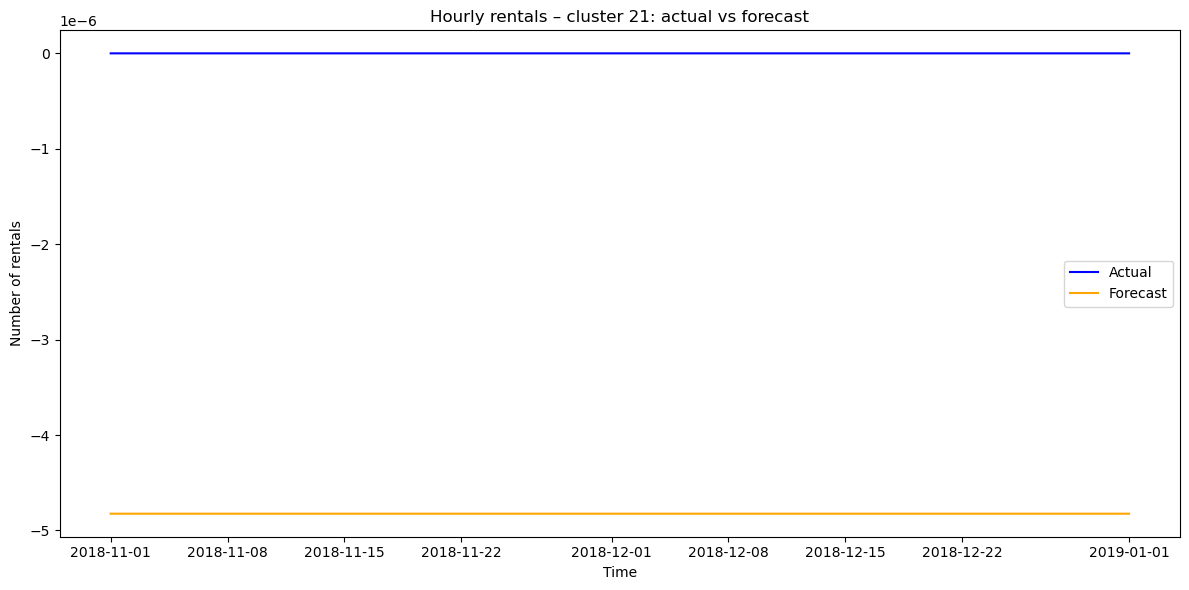

In [51]:
# --- 18. FORECAST AND EVALUATE ---------------------------------------------

n_steps = len(test_data)
predictions = model_fit.forecast(steps=n_steps)

test_data = test_data.copy()
test_data['predicted_num_rentals'] = predictions.values

mae = mean_absolute_error(test_data['num_rentals'], test_data['predicted_num_rentals'])
mse = mean_squared_error(test_data['num_rentals'], test_data['predicted_num_rentals'])
rmse = np.sqrt(mse)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['num_rentals'], label='Actual', color='blue')
plt.plot(test_data.index, test_data['predicted_num_rentals'], label='Forecast', color='orange')
plt.title(f'Hourly rentals – cluster {busiest_cluster_id}: actual vs forecast')
plt.ylabel('Number of rentals')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()
plt.show()
